## 1. Load Packages and Functions

In [1]:
#load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #make autocorrelation plots
from fbprophet import Prophet #forecasting property price
import warnings
warnings.filterwarnings('ignore')

*flowchart*

![flowchart](flowchart.PNG)

In [2]:
def link_data(airbnb_filepath, zillow_filepath, _state, _city):
    """
    Read in the two datasets from file, precross, clean them, and then merge them together by relevant zip codes
    
    airbnb_filepath:string -- path to airbnb data file
    zillow_filepath:string -- path to zillow data file
    _state:string -- State we want to filter by
    _city:string -- City we want to filter by
    
    return a dataframe
    
    """
    airbnb_df = pd.read_csv(airbnb_filepath)
    zillow_df = pd.read_csv(zillow_filepath)#read in data
    
    airbnb_relevant_features = ['last_scraped', 'neighbourhood_cleansed', 'zipcode','property_type', 'bedrooms', 'price',
                                'minimum_nights','number_of_reviews', 'last_review']
    
    airbnb_df = airbnb_df[airbnb_relevant_features]
    airbnb_df = airbnb_df[(airbnb_df.bedrooms ==2) & #find 2-bedroom properties
                          (airbnb_df.minimum_nights < 15) & #only keep price of short-term rental listings
                          (airbnb_df.number_of_reviews > 0) & #should have at least catered guests
                          (pd.to_datetime(airbnb_df.last_review) > 
                            (pd.to_datetime(airbnb_df.last_scraped.max()) + timedelta(days = -180)))]
                            #get most recent scraped date, have reviews in past half year
        
    airbnb_df.price = airbnb_df.price.str.replace("$" , "").str.replace("," , "").astype("float") #clean price data
    
    airbnb_df.zipcode = airbnb_df.zipcode[-airbnb_df.zipcode.isnull()].astype("int") #clean zip codes, remove null
    
    airbnb_df = airbnb_df.groupby("zipcode").agg({"neighbourhood_cleansed":mode, 
                                     "property_type":mode, 
                                     "price":["mean","median","std"],
                                     "number_of_reviews":["sum", "mean"]}) #aggregate data by zipcode
    
    airbnb_df.columns = ['_'.join(tuple(map(str, agg))) for agg in airbnb_df.columns.values] #restore column names
    
    zillow_df.columns = zillow_df.columns.str.lower()
    
    zillow_cols_rmv = ["regionid", "city", "state", "metro"] #vars will be removed

    #filter data by the passed in location and remove unnecessary vars
    zillow_df = zillow_df[(zillow_df.state == _state) & (zillow_df.city == _city)].drop(zillow_cols_rmv, axis = 1)
    
    merged_df = airbnb_df.join(zillow_df.set_index("regionname"), how = "inner") #inner join by zip code
    
    merged_df.index.rename("zipcode", inplace = True) #restore index name
    merged_df.reset_index(inplace = True)
    merged_df.zipcode = merged_df.zipcode.astype("str")
    
    return merged_df
    

In [4]:
def mode(series): 
    """
    helper function that will be used in aggregation
    """
    return series.value_counts().index[0] 

In [6]:
def get_timeseries_df(df):
    """
    produce a timeseries dataframe that will be useful in ploting timeseries data and forecasting
    
    df:DataFrame -- ideally the merged dataframe to produce the timeseries dataframe
    
    return DataFrame
    
    """
    
    years = [col for col in df.columns if col.startswith("1") | col.startswith("2")] #get all the years column name
    
    timeseries_df = df.melt(id_vars = ["zipcode"], value_vars = years, 
                            var_name ="year_month", value_name = "property_price_median") #transpose data in the long format
    
    timeseries_df.year_month = pd.to_datetime(timeseries_df.year_month) #convert to date
    timeseries_df.zipcode = timeseries_df.zipcode.apply(lambda x: x + "-") #add a differentiator after the zipcode 
                                                                        #so that seaborn would not take these as numeric value
    
    return timeseries_df

In [7]:
sns.set_style("whitegrid")

def draw_price_trend(timeseries_df_, most_recent_num_years=50):
    """
    plot property price change over the designated time period
    
    timeseries_df_:DataFrame -- the timeseries dataframe we want to draw from
    most_recent_num_years:int -- counting from the lastest year in the timeseries dataframe, 
                                 how many years of data we want to see, default is 50
    
    """

    fig, ax = plt.subplots(figsize= (10, 8))
    ax = sns.lineplot("year_month", "property_price_median",hue = "zipcode", data = 
                 timeseries_df_[timeseries_df_.year_month > (timeseries_df_.year_month.max() + 
                                                             timedelta(days = -365*most_recent_num_years))]) #filter years
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Property Price Trend")

In [8]:
def draw_seasonality_plot(timeseries_df_, zipcode_, save=False):
    """
    Plot an area's property price data by month by year in the same plot to observe seasonality
    
    timeseries_df_:DataFrame -- the timeseries dataframe we want to draw from
    zipcode_:string -- the zipcode to filter dataframe
    save:boolean -- do we want to save the plot
    
    """
    
    fig, ax = plt.subplots(figsize = (10,8))

    zip_df = timeseries_df_[timeseries_df_.zipcode.str.contains(zipcode_)] #filter by the zipcode
    zip_df['year'] = [d.year for d in zip_df.year_month] #get years
    zip_df['month'] = [d.month for d in zip_df.year_month] #get months
    years = zip_df['year'].unique() #only keep unique years

    colors = sns.color_palette("husl",len(years)) #set colors for different year

    for i, year in enumerate(years):      
            ax = sns.lineplot("month", "property_price_median", data=zip_df.loc[zip_df.year==year, :], color=colors[i])
            ax.text(zip_df.loc[zip_df.year==year, :].shape[0]+0.1, 
                     zip_df.loc[zip_df.year==year, 'property_price_median'][-1:].values[0], 
                     year, fontsize=14, color = colors[i]) #annotation
    ax.set_title("Zip Code: " + zipcode_)
    
    if save == True:
        fig.savefig("{}_seasonal_plot".format(zipcode_)) #save


In [9]:
def get_zipcode_df(timeseries_df_, zipcode_):
    """
    helper function to get timeseries dataframe by a particular zipcode
    
    timeseries_df_:DataFrame -- timeseries dataframe to pull from
    zipcode_:string -- zipcode
    
    return DataFrame
    """
    zip_df = timeseries_df_[-timeseries_df_.property_price_median.isnull()].set_index("year_month") #filter null data
    zip_df = zip_df[zip_df.zipcode.str.contains(zipcode_)] #use contains to be flexible with xxxxx- and xxxxx
    
    return zip_df

In [10]:
def draw_seasonal_decomposation_plot(timeseries_df_, zipcode_):
    """
    draw seasonal decomposation plot using the stats module
    
    timeseries_df_:DataFrame -- timeseries dataframe to pull from
    zipcode_:string -- zipcode
    """
    
    zip_df = get_zipcode_df(timeseries_df_, zipcode_) #get timeseries dataframe by zipcode
    
    additive_mdl = sm.tsa.seasonal_decompose(zip_df["property_price_median"], 
                                       model='additive') #set model as additive

    plt.rcParams.update({'figure.figsize': (8,8)}) #resize
    additive_mdl.plot()
    plt.show()

In [11]:
def draw_autocorr_plot(timeseries_df_, zipcode_):
    """
    draw autocorrelation plots on zipcode
    
    timeseries_df_:DataFrame -- timeseries dataframe to pull from
    zipcode_:string -- zipcode
    """
    zip_df = get_zipcode_df(timeseries_df_, zipcode_)
    
    fig, ax = plt.subplots(1,2,figsize=(13,5))
    plot_acf(zip_df.property_price_median.tolist(), lags=50, ax=ax[0])
    plot_pacf(zip_df.property_price_median.tolist(), lags=50, ax=ax[1])

In [12]:
def fit_property_price_models(timeseries_df_, predict_months):
    """
    fit forecasting model using Facebook's prophet package and make predictions
    
    timeseries_df_:DataFrame -- timeseries dataframe to fit and predict from
    predict_months:int -- how many months ahead we want to predict, starting from the last data in the data frame
    
    return fitted models and forecasts dictionaries, keys are zipcodes
    
    """
    
    zip_models = {}
    zip_forecasts = {}
    
    for zipcode_ in timeseries_df.zipcode.unique():
        zip_model = Prophet(interval_width=0.95) #set confidence interval
        zip_df = get_zipcode_df(timeseries_df, zipcode_) 
        zip_df = zip_df.reset_index().rename(columns={'year_month': 'ds', 'property_price_median': 'y'}) #rename col for the model
        zip_model.fit(zip_df) #fit model
        
        zip_forecast = zip_model.make_future_dataframe(periods=predict_months, freq='MS')
        zip_forecast = zip_model.predict(zip_forecast) #make predictions
        
        zip_models[zipcode_] = zip_model
        zip_forecasts[zipcode_] = zip_forecast #store models
        
    
    return zip_models, zip_forecasts
        

In [13]:
def concat_predicted_value(orginal_df, forecasts, pred_ymd):
    """
    Choose a certain year and month of prediction and concatenate it back to the old dataframe
    
    orginal_df:DataFrame -- dataframe to be concatenated to
    forecast:Dictionary -- the forecast dictionary obtained from the fit_property_price_models function
    pred_ymd:Date -- the certain year and month of prediction we want with format "yyyy-mm-01"
    
    return DataFrame
    
    """
    key_list = []
    value_list = []

    for key, forecast in forecasts.items():
        key = key.replace("-", "") #remove the post-fix for join match
        predicted_value = forecast[forecast.ds == pred_ymd]['yhat'].tolist()[0]
        key_list.append(key)
        value_list.append(predicted_value)

    predicted_df = pd.DataFrame({"zipcode":key_list, pred_ymd:value_list})

    return predicted_df.merge(merged_df) #join

In [40]:
def draw_scatter(df, x_col, y_col, hue_col, annotation_col):
    """
    draw a scatter plot on two dimensions of the data and annotate by a column
    
    df:DataFrame -- dataframe of the data that is stored
    x_col:string -- data to be drawn on the X-axis
    y_col:string -- data to be drawn on the Y-axis
    hue_col:string -- color differentiate data by this column
    annotation_col:string -- annotate the data pointing by this column
    """
    sns.set_style("darkgrid") #set background if want to
    
    fig, ax = plt.subplots(figsize= (10, 8))

    ax = sns.scatterplot(x=x_col, y = y_col, hue = hue_col, size = hue_col, sizes = (20, 200), data = df)
    
    #annotation
    for line in range(0, merged_df.shape[0]):
        ax.text(df[x_col].iloc[line]-10, df[y_col].iloc[line]+60000, df[annotation_col].iloc[line],
             horizontalalignment='left', size='medium', color='black', alpha = 0.5)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #place legend outside of the graph
    ax.set_title(x_col + " V.S " + y_col + " V.S " + hue_col, fontsize = 16)    
    

**Map drawing codes are referenced from online articles**   

**Codes are tinkered for the particular use of this project**

Credit:    
https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f   
https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac


In [14]:
#import urllib.request

"""
New York City map data obtained from a open source flatform

url to download is provided below

https://data.cityofnewyork.us/download/i8iw-xf4u/application/zip
"""

#urllib.request.urlretrieve("https://data.cityofnewyork.us/download/i8iw-xf4u/application/zip", 
#                          "C:\\Users\\没有密码的电脑\\Downloads\\map.zip")

'\nNew York City map data obtained from a open source flatform\n\nurl to download is provided below\n\nhttps://data.cityofnewyork.us/download/i8iw-xf4u/application/zip\n'

In [15]:
import shapefile as shp

#initiating the may
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

shp_path = "./ZIP_CODE_040114/ZIP_CODE_040114.shp"
dbf_path = "./ZIP_CODE_040114/ZIP_CODE_040114.dbf"

sf = shp.Reader(shp_path, dbf_path)

In [16]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe 
    
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [19]:
def calc_color(data, color=None):
    """
    caculate gradient color for heating map
    """
    
    if color == 1: 
        color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0','#807dbaF0','#6a51a3F0','#54278fF0']
        colors = 'Purples'
    elif color == 2: 
        color_sq = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494']
        colors = 'YlGnBu'
    elif color == 3: 
        color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']
        colors = 'Greys'
    elif color == 9: 
        color_sq = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
    else:            
        color_sq = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404']
        colors = 'YlOrBr'

    new_data, bins = pd.qcut(data, 6, retbins=True, 
    labels=list(range(6)))
    color_ton = []
    for val in new_data:
        color_ton.append(color_sq[val]) 
    if color != 9:
        colors = sns.color_palette(colors, n_colors=6)
        sns.palplot(colors, 0.6);
        for i in range(6):
            print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                   " => "+str(int(bins[i+1])-1), end =" ")
        print("\n\n   1   2   3   4   5   6")    
    return color_ton, bins;

In [20]:
def plot_map_fill_multiples_ids_tone(sf, title, zip_id,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
   
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in zip_id:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[zip_id.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [21]:
def plot_zipcodes_data(sf, title, zipcodes, data=None,color=None, print_id=False):
    
    """
    plot selected data on the corresponding zipcode area
    
    
    sf:shapefile object -- shapefile that's read in
    title:string -- title of the plot
    zipcodes:list -- a list of zipcodes to filter by
    data:list -- a list of data to be colored on the corresponding zipcode area
    color:int -- color palette choice
    print_id:boolean -- whether to plot zipcode id from the shapefile
    
    """

    color_ton, bins = calc_color(data, color)
   
    df = read_shapefile(sf)
    zipcode_ids = []
    for zc in zipcodes:
        zipcode_ids.append(df[df.ZIPCODE == zc].index[0])
        
    plot_map_fill_multiples_ids_tone(sf, title, zipcode_ids, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9));

## 2. Begin Analysis

In [22]:
merged_df = link_data("listings.csv", "Zip_Zhvi_2bedroom.csv", "NY", "New York") #read in data

merged_df.head()

,zipcode,neighbourhood_cleansed_mode,property_type_mode,price_mean,price_median,price_std,number_of_reviews_sum,number_of_reviews_mean,countyname,sizerank,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,10003,East Village,Apartment,328.377358,260.0,180.594768,2823,53.264151,New York,21,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000
1,10011,Chelsea,Apartment,378.454545,357.5,148.221935,1570,35.681818,New York,15,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
2,10013,Tribeca,Apartment,397.707317,350.0,234.380273,1255,30.609756,New York,1744,...,3347100,3305500,3261100,3244000.0,3231400,3183300,3160200,3193500,3262200,3316500
3,10014,West Village,Apartment,346.593750,300.0,193.068575,1073,33.531250,New York,379,...,2480800,2443200,2430100,2452900.0,2451200,2441900,2460900,2494900,2498400,2491600
4,10021,Upper East Side,Apartment,224.875000,227.0,104.143359,348,43.500000,New York,190,...,1668300,1664800,1659500,1656000.0,1643700,1649800,1688500,1731400,1774100,1815600


In [23]:
timeseries_df = get_timeseries_df(merged_df) #get timeseries dataframe

timeseries_df.head()

,zipcode,year_month,property_price_median
0,10003-,1996-04-01,NaN
1,10011-,1996-04-01,NaN
2,10013-,1996-04-01,NaN
3,10014-,1996-04-01,NaN
4,10021-,1996-04-01,NaN


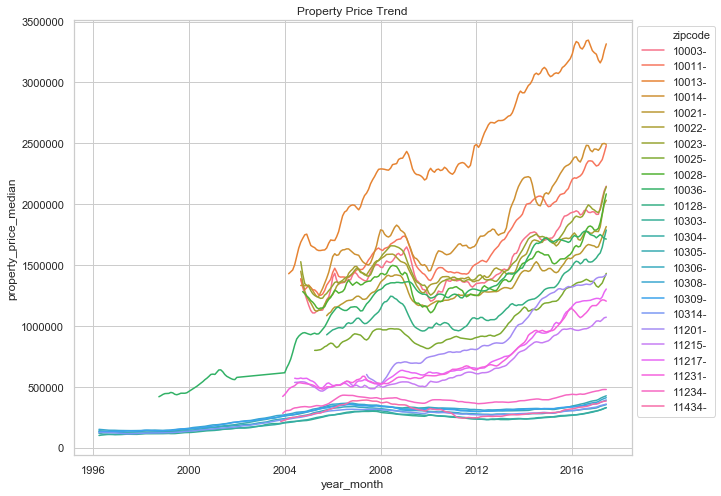

In [26]:
draw_price_trend(timeseries_df)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


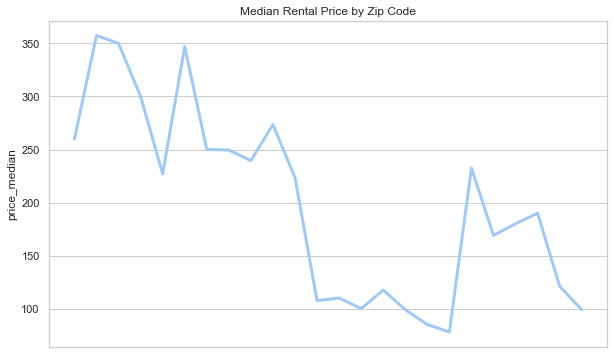

In [92]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = merged_df, x = "zipcode", y = "price_median", markers = "o", linewidth = 3)
ax.axes.xaxis.set_visible(False)
ax.set_title("Median Rental Price by Zip Code");


In [64]:
sns.lineplot

<function seaborn.relational.lineplot(x=None, y=None, hue=None, size=None, style=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, dashes=True, markers=None, style_order=None, units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, err_style='band', err_kws=None, legend='brief', ax=None, **kwargs)>

In [41]:
models, forecasts = fit_property_price_models(timeseries_df, 30) #fit models to predict price

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

In [46]:
final_df = concat_predicted_value(merged_df, forecasts, "2019-07-01") #bind predicted values to the original data 
final_df.head()

,zipcode,2019-07-01,neighbourhood_cleansed_mode,property_type_mode,price_mean,price_median,price_std,number_of_reviews_sum,number_of_reviews_mean,countyname,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,10003,2.334609e+06,East Village,Apartment,328.377358,260.0,180.594768,2823,53.264151,New York,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000
1,10011,2.715698e+06,Chelsea,Apartment,378.454545,357.5,148.221935,1570,35.681818,New York,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
2,10013,3.549018e+06,Tribeca,Apartment,397.707317,350.0,234.380273,1255,30.609756,New York,...,3347100,3305500,3261100,3244000.0,3231400,3183300,3160200,3193500,3262200,3316500
3,10014,2.853163e+06,West Village,Apartment,346.593750,300.0,193.068575,1073,33.531250,New York,...,2480800,2443200,2430100,2452900.0,2451200,2441900,2460900,2494900,2498400,2491600
4,10021,1.923036e+06,Upper East Side,Apartment,224.875000,227.0,104.143359,348,43.500000,New York,...,1668300,1664800,1659500,1656000.0,1643700,1649800,1688500,1731400,1774100,1815600



1: -4647 => -1980 
2: -1979 => -1115 
3: -1114 => -480 
4: -479 => -71 
5: -70 => -21 
6: -20 => -2 

   1   2   3   4   5   6


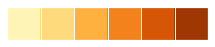

<Figure size 792x648 with 0 Axes>

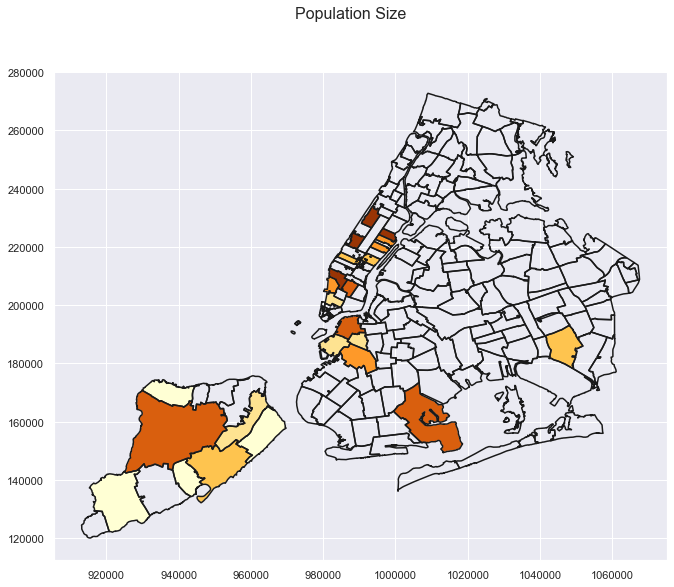

In [213]:
plot_cities_data(sf, "Population Size", final_df.zipcode, data = -final_df.sizerank, color = 6)


1: 333658 => 388534 
2: 388535 => 497729 
3: 497730 => 1552760 
4: 1552761 => 1987454 
5: 1987455 => 2315664 
6: 2315665 => 3549017 

   1   2   3   4   5   6


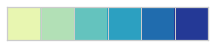

<Figure size 792x648 with 0 Axes>

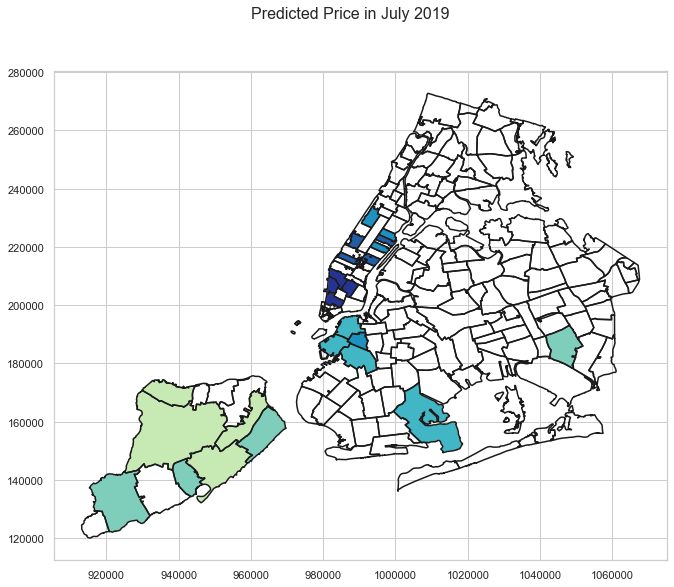

In [226]:
plot_cities_data(sf, "Predicted Price in July 2019", final_df.zipcode, data = final_df["2019-07-01"], color = 2)


1: 78 => 98 
2: 99 => 118 
3: 119 => 205 
4: 206 => 241 
5: 242 => 276 
6: 277 => 356 

   1   2   3   4   5   6


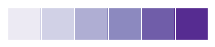

<Figure size 792x648 with 0 Axes>

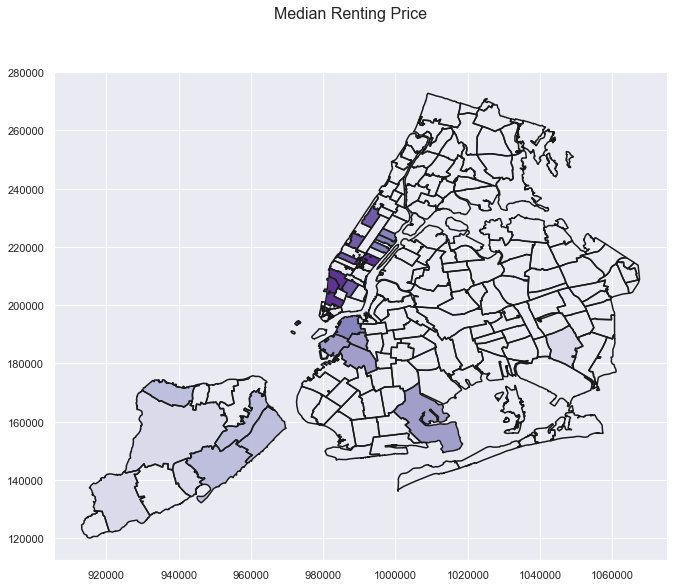

In [223]:
plot_cities_data(sf, "Median Renting Price", final_df.zipcode, data = final_df.price_median, color = 1)

In [212]:
final_df["years_to_breakeven"] = final_df["2019-07-01"]/(final_df.price_median * 365 * 0.75) #calculate years to breakeven

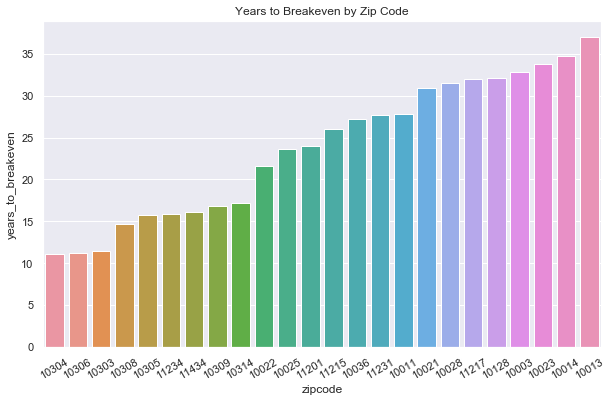

In [216]:
sns.barplot("zipcode", "years_to_breakeven", data =final_df, order= final_df.sort_values("years_to_breakeven").zipcode)
plt.xticks(rotation=30)
plt.title("Years to Breakeven by Zip Code"); 

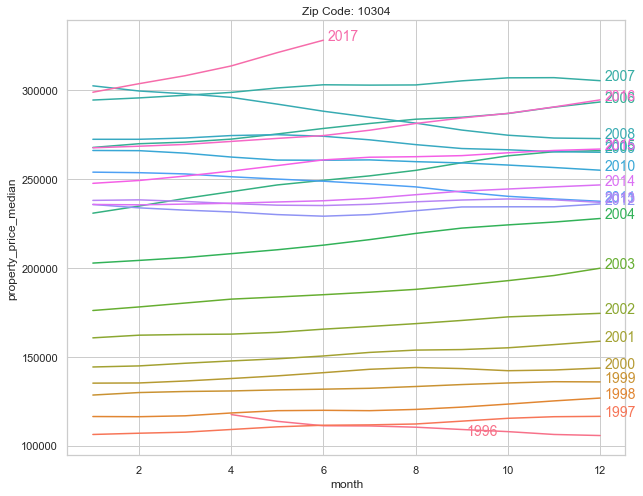

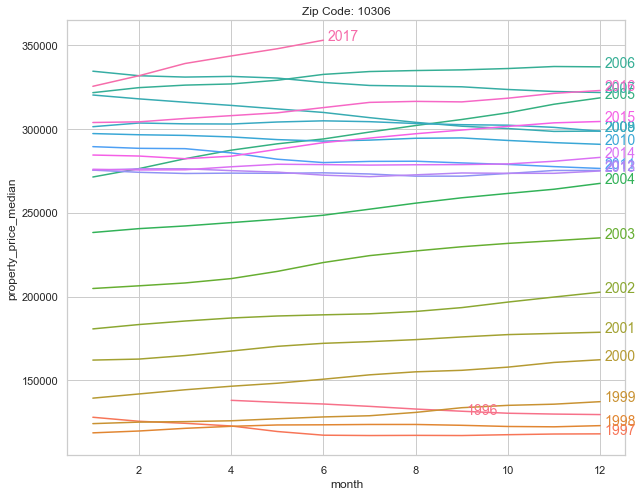

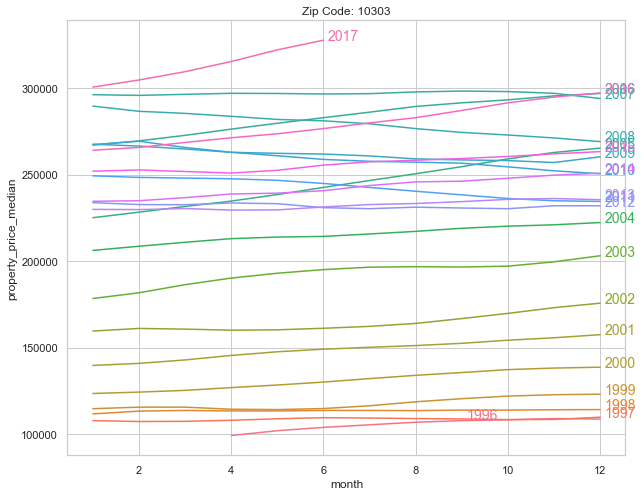

In [229]:
for z in ["10304","10306","10303"]:
    draw_seasonality_plot(timeseries_df, z) #seasonaility plot for the top 3 zipcode

<Figure size 720x576 with 0 Axes>

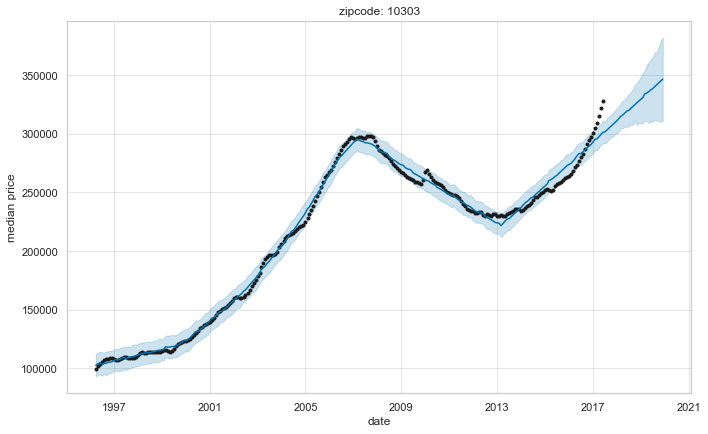

In [227]:
#price forecast with 0.95 confidence interval
plt.figure(figsize=(10, 8))
models["10303-"].plot(forecasts["10303-"], xlabel = 'date', ylabel = 'median price')
plt.title('zipcode: 10303');

In [47]:
final_df["property_price_difference"] = final_df["2019-07-01"] - final_df["2017-06"]

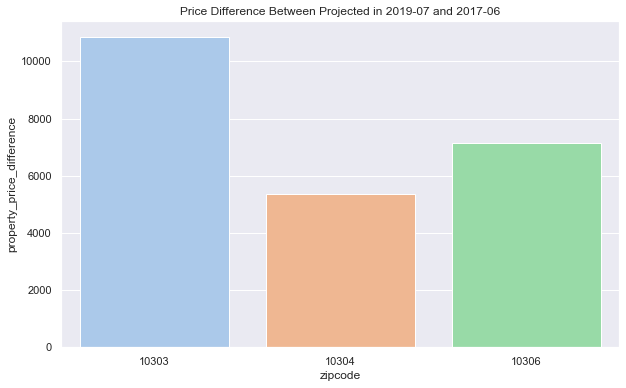

In [48]:
sns.barplot(x = "zipcode", y = "property_price_difference", data = final_df[final_df.zipcode.isin(["10303", "10304", "10306"])])
plt.title("Price Difference Between Projected in 2019-07 and 2017-06");

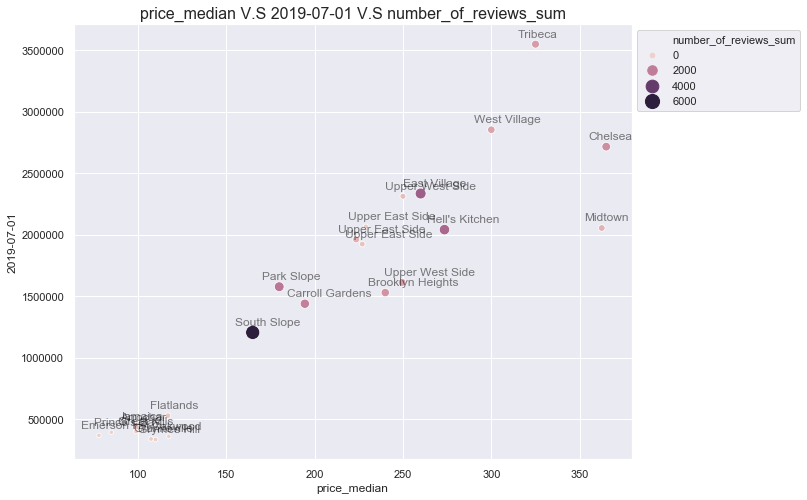

In [199]:
#factor in number of difference
draw_scatter(final_df, "price_median", "2019-07-01", "number_of_reviews_sum", "neighbourhood_cleansed_mode")

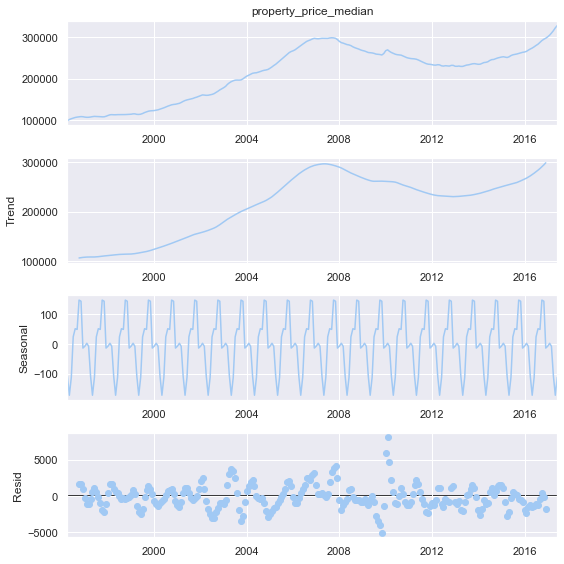

In [247]:
## we can do some further analysis on the timeseries 
sns.set_style("darkgrid")
draw_seasonal_decomposation_plot(timeseries_df, "10303")

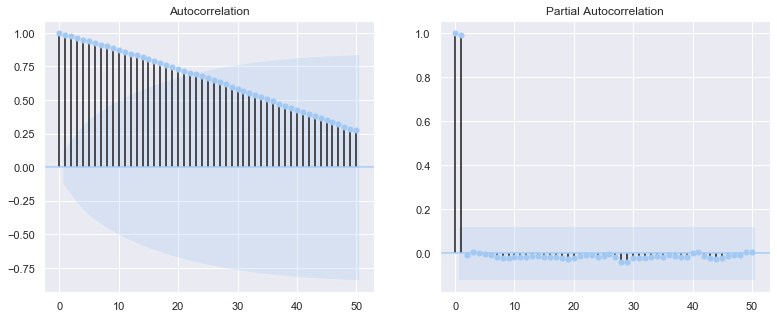

In [246]:
draw_autocorr_plot(timeseries_df, "10303")